In [1]:
#libraries for dataframe
import pandas as pd
import numpy as np

#libraries for visulaization
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for sentiment analysis
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

#librareis for modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import spacy

In [2]:
df = pd.read_csv("C://code/tsm_label_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   TITLE                   131 non-null    object
 1   publisher_name          131 non-null    object
 2   content                 131 non-null    object
 3   publication_date        131 non-null    object
 4   link                    131 non-null    object
 5   Label (Fake-0| True-1)  131 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 6.3+ KB


In [4]:
df.describe()

,Label (Fake-0| True-1)
count,131.000000
mean,0.465649
std,0.500733
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
df.head(5)

,TITLE,publisher_name,content,publication_date,link,Label (Fake-0| True-1)
0,True! Sierra Leone was elected as a non-perman...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permane...,11/07/2023,https://tsmliberia.com/true-sierra-leone-was-e...,1
1,"Correct, Costa Got 8 Percent In 2017 Elections",R. Joyclyn Wea,"Claim: Henry Costa only got 3,287 votes which ...",11/07/2023,https://tsmliberia.com/correct-costa-got-8-per...,1
2,What Did Representative Foko Say about Weah’s ...,Mark Mengonfia,There have been a variety of responses to a st...,08/07/2023,https://tsmliberia.com/what-did-representative...,1
3,The Post of Costa For President is Misleading,Mark Mengonfia,Claim: Henry Costa to contest the 2023 preside...,30/06/2023,https://tsmliberia.com/the-post-of-costa-for-p...,0
4,June Pidgin Edition,The Stage Media-Liberia,We have done a round of fact-checks in Liberia...,28/06/2023,https://tsmliberia.com/june-pidgin-edition/,1


In [6]:
#topic labelling

 #the labels column name contains paranthesis and special characters which may cause problems. That's why we will replace it. 
df.rename(columns={"Label (Fake-0| True-1)": "label"}, inplace=True)

y = df.label
print("Ratio of Real and Fake news")
y.value_counts(normalize = True).rename({1:"Real", 0:"Fake" }) 

Ratio of Real and Fake news


Fake    0.534351
Real    0.465649
Name: label, dtype: float64

In [7]:
#Calculating the number of missing values

df.isnull().sum()

TITLE               0
publisher_name      0
content             0
publication_date    0
link                0
label               0
dtype: int64

That's great we have no null values. So we are free from the issue of handling missing values

In [8]:
df.nunique()

TITLE               131
publisher_name        8
content             131
publication_date    112
link                131
label                 2
dtype: int64

### Merging the title and content column

 W
e will merge the title and content column because of few reasons

#### 1. Contextual Information: 
The title and content column might contain same information. So, by meging them we can get both the title and content in the single field. This will provide more comprehensive textual data, capturing important context and details in a unified manner

#### 2. Model Input:
We want to train the model onto the text data. So many NLP models are designed to take single text input data, so merging the title and content allow us to use full text of the news article as the input data. 

#### 3. Text cleaning: 
By merging the title and content column we can clean both columns at the same time. Otherwise we have to apply each step separately on botht he columns. 

In [9]:
df.rename(columns = {"TITLE":"title"}, inplace = True)
df["title_content"] = df["title"] + df["content"]

We will also create the column of "body_length" which indicates the length of the article. This additional feature will help us in analyzing whether the news is real or fake based on the article's length

In [10]:
df["text_length"] = df["title_content"].apply(lambda x: len(x) - x.count(" "))
df.head()

,title,publisher_name,content,publication_date,link,label,title_content,text_length
0,True! Sierra Leone was elected as a non-perman...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permane...,11/07/2023,https://tsmliberia.com/true-sierra-leone-was-e...,1,True! Sierra Leone was elected as a non-perman...,3081
1,"Correct, Costa Got 8 Percent In 2017 Elections",R. Joyclyn Wea,"Claim: Henry Costa only got 3,287 votes which ...",11/07/2023,https://tsmliberia.com/correct-costa-got-8-per...,1,"Correct, Costa Got 8 Percent In 2017 Elections...",1961
2,What Did Representative Foko Say about Weah’s ...,Mark Mengonfia,There have been a variety of responses to a st...,08/07/2023,https://tsmliberia.com/what-did-representative...,1,What Did Representative Foko Say about Weah’s ...,1164
3,The Post of Costa For President is Misleading,Mark Mengonfia,Claim: Henry Costa to contest the 2023 preside...,30/06/2023,https://tsmliberia.com/the-post-of-costa-for-p...,0,The Post of Costa For President is MisleadingC...,1397
4,June Pidgin Edition,The Stage Media-Liberia,We have done a round of fact-checks in Liberia...,28/06/2023,https://tsmliberia.com/june-pidgin-edition/,1,June Pidgin EditionWe have done a round of fac...,112


In [11]:
average_length_real_news = df[df["label"] == 1]["text_length"].mean()
average_length_real_news

3117.8032786885246

In [12]:
average_length_fake_news = df[df["label"] == 0]["text_length"].mean()
average_length_fake_news

2773.1

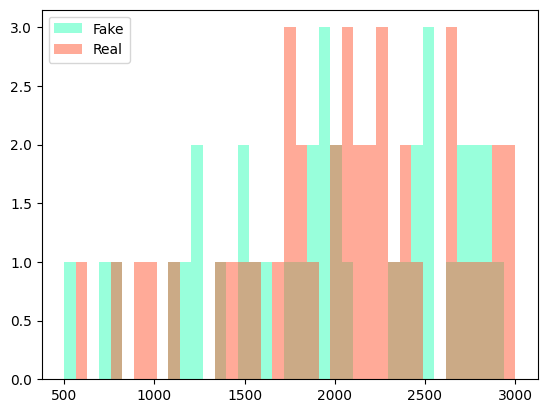

In [13]:
bins = np.linspace(500, 3000, 40)
plt.hist(df[df["label"] == 1]["text_length"], bins, alpha = 0.5, label = "Fake", color="#33FFB8")
plt.hist(df[df["label"] == 0]["text_length"], bins ,alpha = 0.5, label = "Real", color = "#FF5733")
plt.legend(loc = "upper left")
plt.show()

We can conclude that text length will not help us much in this scenario. 

### Class distribution Analysis

Text(0.5, 1.0, 'Distribution of Fake/Real News')

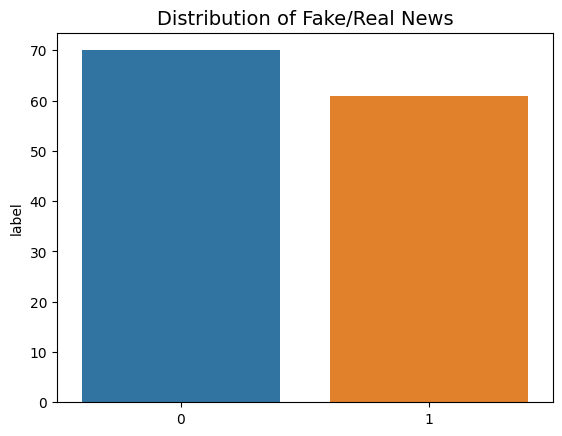

In [14]:
class_names = ["Real", "Fake"]
label_counts = df.label.value_counts()
sns.barplot(x = label_counts.index, y = label_counts)
plt.title('Distribution of Fake/Real News',fontsize =14)


In [15]:
real_news = df[df["label"] == 1] #Creating the dateset contain only Real news
real_news

,title,publisher_name,content,publication_date,link,label,title_content,text_length
0,True! Sierra Leone was elected as a non-perman...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permane...,11/07/2023,https://tsmliberia.com/true-sierra-leone-was-e...,1,True! Sierra Leone was elected as a non-perman...,3081
1,"Correct, Costa Got 8 Percent In 2017 Elections",R. Joyclyn Wea,"Claim: Henry Costa only got 3,287 votes which ...",11/07/2023,https://tsmliberia.com/correct-costa-got-8-per...,1,"Correct, Costa Got 8 Percent In 2017 Elections...",1961
2,What Did Representative Foko Say about Weah’s ...,Mark Mengonfia,There have been a variety of responses to a st...,08/07/2023,https://tsmliberia.com/what-did-representative...,1,What Did Representative Foko Say about Weah’s ...,1164
4,June Pidgin Edition,The Stage Media-Liberia,We have done a round of fact-checks in Liberia...,28/06/2023,https://tsmliberia.com/june-pidgin-edition/,1,June Pidgin EditionWe have done a round of fac...,112
5,The Cut in the 2023 Elections Budget,Gloria Wleh,"In March this year, the Chairperson of the Nat...",23/06/2023,https://tsmliberia.com/the-cut-in-the-2023-ele...,1,The Cut in the 2023 Elections BudgetIn March t...,4332
...,...,...,...,...,...,...,...,...
126,Did 82 Percent of Liberians Agree to Transitio...,The Stage Media-Liberia,Pic Credit: FPAClaim: “82.2 percent of the Lib...,09/09/2021,https://tsmliberia.com/did-82-percent-of-liber...,1,Did 82 Percent of Liberians Agree to Transitio...,2907
127,Facebook account using the image and name of H...,The Stage Media-Liberia,Facebook(social Media)Claim: A Facebook page p...,07/09/2021,https://tsmliberia.com/facebook-account-using-...,1,Facebook account using the image and name of H...,1618
128,Scam Alert: Coca Cola is not Running a Survey,The Stage Media-Liberia,social media user alertClaim: A survey about a...,07/09/2021,https://tsmliberia.com/scam-alert-coca-cola-is...,1,Scam Alert: Coca Cola is not Running a Surveys...,1244
129,Are Motor Vehicles and Pedestrians Still Plyi...,The Stage Media-Liberia,social mediaClaim: A most recent circulating ...,06/09/2021,https://tsmliberia.com/are-motor-vehicles-and-...,1,Are Motor Vehicles and Pedestrians Still Plyi...,2298


## WordCloud


Text(0.5, 1.0, 'Frequent words in Real news')

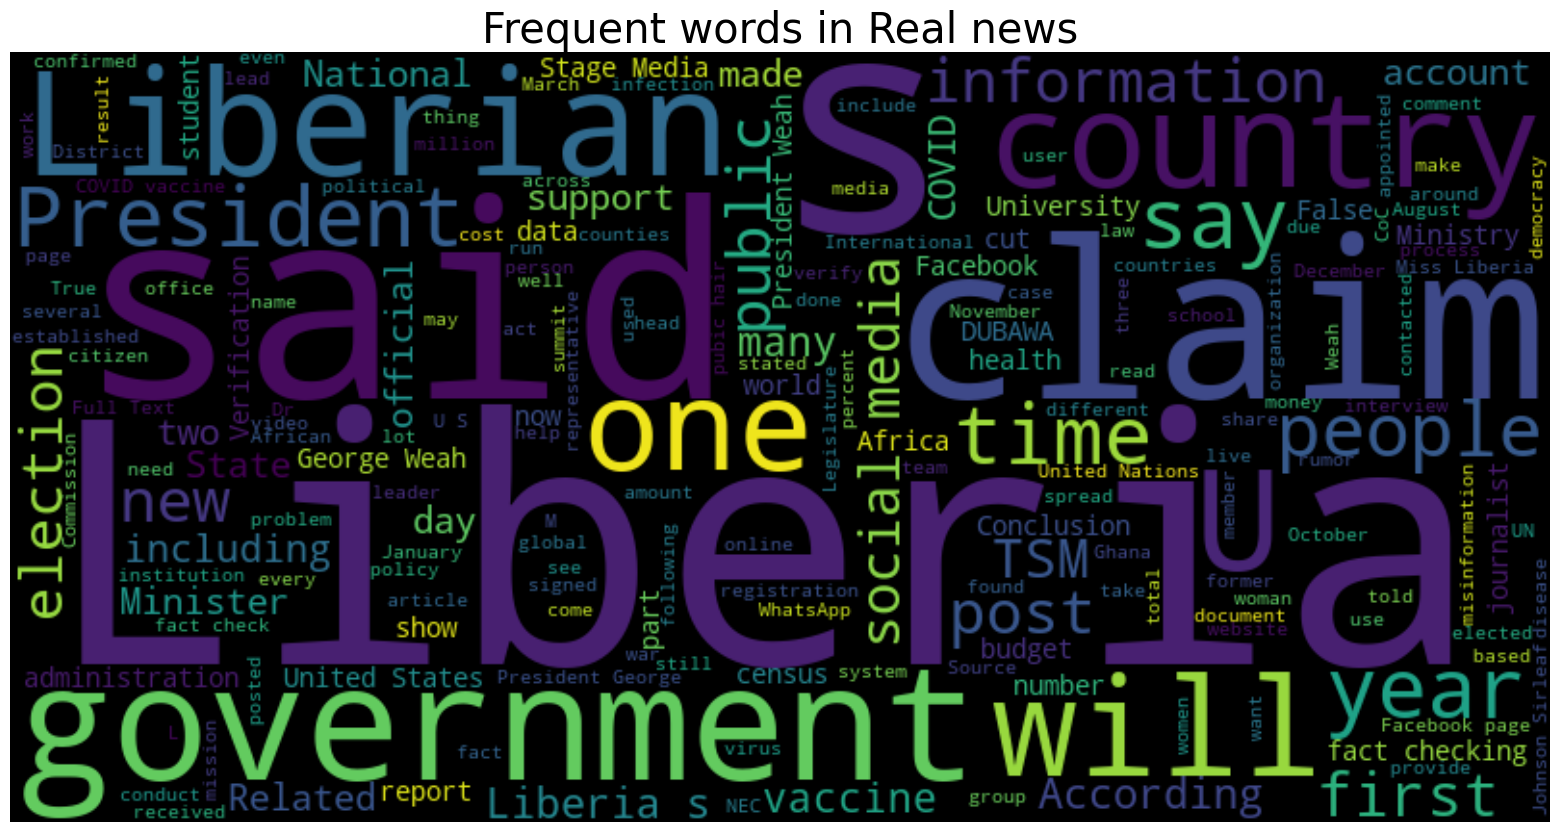

In [16]:
#Generating wordcloud for important words in real news text
real_text = " ".join(title_content for title_content in real_news["title_content"]) 
word_cloud = WordCloud(
    background_color = "black",
    max_words = 200,
    width = 800,
    height = 400,
    random_state = 42).generate(real_text)
plt.figure(figsize = (20,10))
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Frequent words in Real news", fontsize = 30)

In [17]:
#Now we will create the dataset containing only fake news
fake_news = df[df["label"] == 0]
fake_news

,title,publisher_name,content,publication_date,link,label,title_content,text_length
3,The Post of Costa For President is Misleading,Mark Mengonfia,Claim: Henry Costa to contest the 2023 preside...,30/06/2023,https://tsmliberia.com/the-post-of-costa-for-p...,0,The Post of Costa For President is MisleadingC...,1397
6,Is UP Ticket a Ritual Ticket?,Bettie Johnson-Mbayo,We have tracked thirty-four social media accou...,22/06/2023,https://tsmliberia.com/is-up-ticket-a-ritual-t...,0,Is UP Ticket a Ritual Ticket?We have tracked t...,3231
7,Is President Weah Correct on the Construction ...,Bettie Johnson-Mbayo,Claim: This government has built more hospital...,21/06/2023,https://tsmliberia.com/is-president-weah-corre...,0,Is President Weah Correct on the Construction ...,3072
8,"False, Liberia did not rank 135 in 2017 and 15...",Gloria Wleh,Claim: FIFA World Rankings under Joseph Nyumah...,19/06/2023,https://tsmliberia.com/false-liberia-did-not-r...,0,"False, Liberia did not rank 135 in 2017 and 15...",2932
10,"No, Srimex was not shut down due to tax Evasio...",Maima Wright,Claim: Liberia Revenue Authority Shuts down Mu...,17/06/2023,https://tsmliberia.com/no-srimex-was-not-shut-...,0,"No, Srimex was not shut down due to tax Evasio...",4167
...,...,...,...,...,...,...,...,...
109,Was the Transit Authority Driver Shot?,The Stage Media-Liberia,Screenshot of Martin Kollie' postClaim: The Li...,15/12/2021,https://tsmliberia.com/was-the-transit-authori...,0,Was the Transit Authority Driver Shot?Screensh...,2951
110,Explainer: Who Is Funding Construction of the ...,The Stage Media-Liberia,"On February 9, 2021, President George Weah bro...",14/12/2021,https://tsmliberia.com/explainer-who-is-fundin...,0,Explainer: Who Is Funding Construction of the ...,5222
113,Unverified: Data Showing Candidates and Percen...,The Stage Media-Liberia,Claim: Viral graphic showing candidates and pe...,17/11/2021,https://tsmliberia.com/unverified-graphic-show...,0,Unverified: Data Showing Candidates and Percen...,628
114,Quick Checks: Hurried On: Claim from Bomi By-E...,The Stage Media-Liberia,Bomi Senator screenshot postClaim: Bomi County...,17/11/2021,https://tsmliberia.com/quick-checks-hurried-on...,0,Quick Checks: Hurried On: Claim from Bomi By-E...,782


Text(0.5, 1.0, 'Frequent words in Fake news')

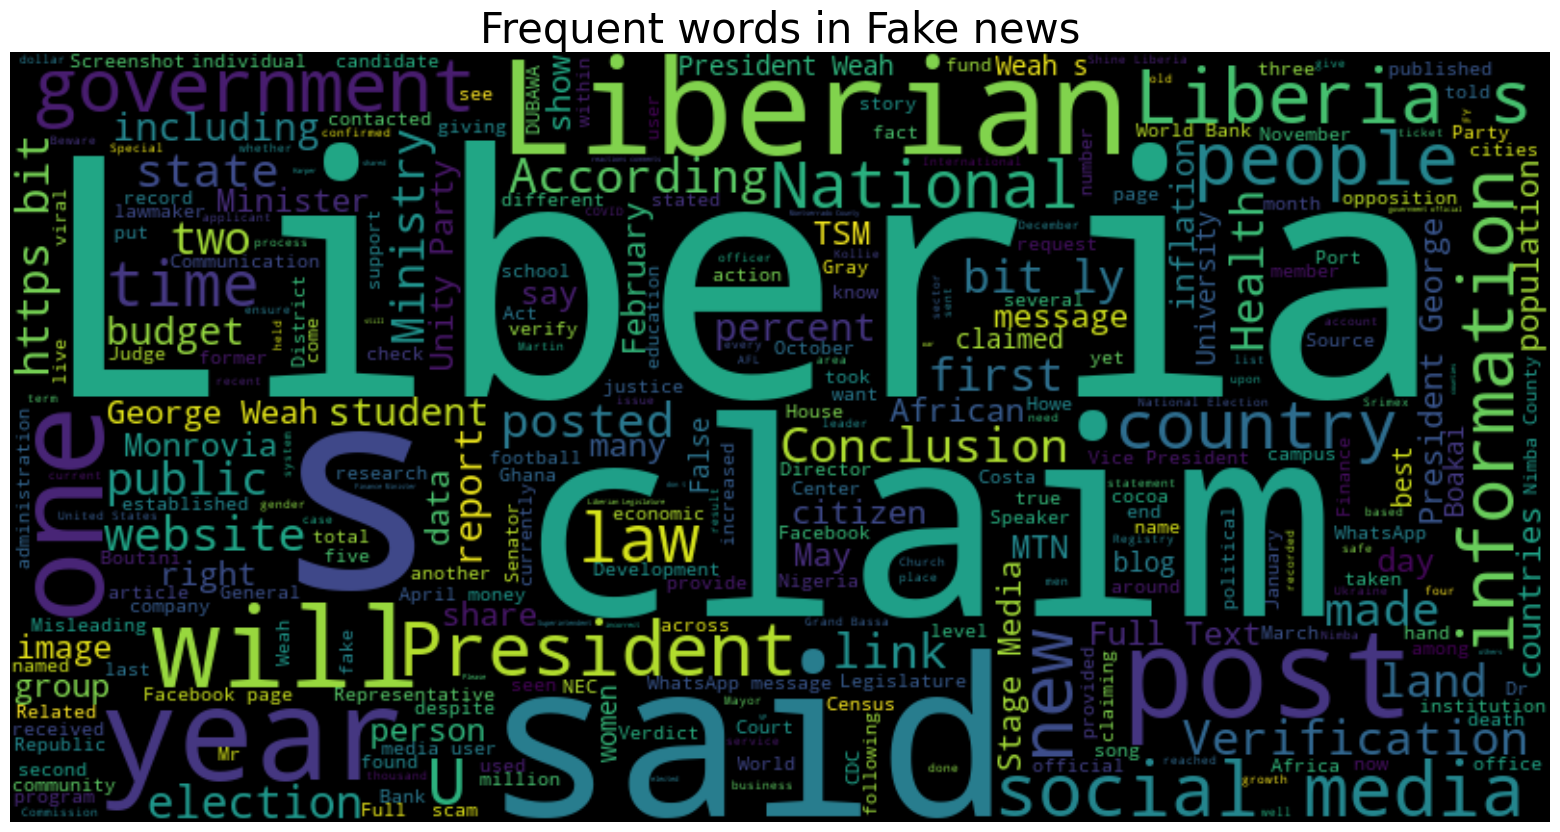

In [18]:
#Generating wordcloud for important words in real news text
fake_text = " ".join(title_content for title_content in fake_news["title_content"])
word_cloud = WordCloud(
    background_color = "black",
    max_words = 300,
    width = 800,
    height = 400,
    random_state = 42).generate(fake_text)
plt.figure(figsize = (20, 10))
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Frequent words in Fake news", fontsize = 30)

## Sentiment Analysis

In [19]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to C:\Users\Kashaf
[nltk_data]     Jamil\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

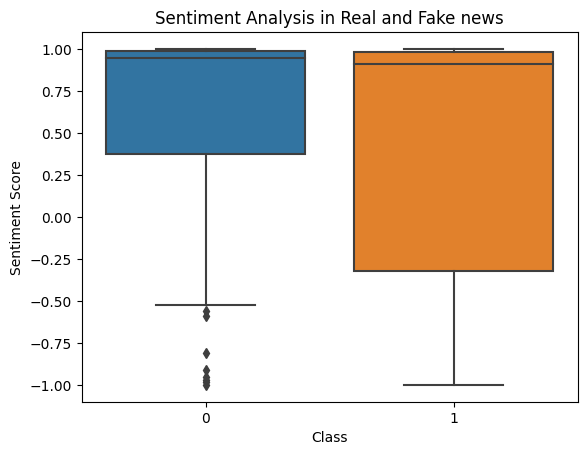

In [20]:
sentiment_analysis = SentimentIntensityAnalyzer()
df["sentiment_score"] = df["title_content"].apply(lambda x: sentiment_analysis.polarity_scores(x)["compound"])
sns.boxplot(data=df, x='label', y='sentiment_score')
plt.title('Sentiment Analysis in Real and Fake news')
plt.xlabel('Class')
plt.ylabel('Sentiment Score')
plt.show()

In [21]:
df.head()

,title,publisher_name,content,publication_date,link,label,title_content,text_length,sentiment_score
0,True! Sierra Leone was elected as a non-perman...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permane...,11/07/2023,https://tsmliberia.com/true-sierra-leone-was-e...,1,True! Sierra Leone was elected as a non-perman...,3081,0.9923
1,"Correct, Costa Got 8 Percent In 2017 Elections",R. Joyclyn Wea,"Claim: Henry Costa only got 3,287 votes which ...",11/07/2023,https://tsmliberia.com/correct-costa-got-8-per...,1,"Correct, Costa Got 8 Percent In 2017 Elections...",1961,0.9079
2,What Did Representative Foko Say about Weah’s ...,Mark Mengonfia,There have been a variety of responses to a st...,08/07/2023,https://tsmliberia.com/what-did-representative...,1,What Did Representative Foko Say about Weah’s ...,1164,0.9102
3,The Post of Costa For President is Misleading,Mark Mengonfia,Claim: Henry Costa to contest the 2023 preside...,30/06/2023,https://tsmliberia.com/the-post-of-costa-for-p...,0,The Post of Costa For President is MisleadingC...,1397,-0.2139
4,June Pidgin Edition,The Stage Media-Liberia,We have done a round of fact-checks in Liberia...,28/06/2023,https://tsmliberia.com/june-pidgin-edition/,1,June Pidgin EditionWe have done a round of fac...,112,0.3182


## Named Entity Recognition (NER) Analysis 

NER helps in identifying important entities in news articles like politicians, organizations, and locations, aiding in spotting inconsistencies and falsehoods in fake news. It assists in fact-checking by verifying entities with reliable sources, ensures contextual understanding of entities for assessing credibility, identifies named sources, reveals patterns and biases, and serves as features for ML models in fake news detection.

In [22]:
nlp = spacy.load("en_core_web_sm")

In [23]:
def get_entities(text):
    parsed_text = nlp(text)
    entities = list(parsed_text.ents)
    named_entities = []
    for entity in entities:
        if entity.label_ in ["ORG", "PERSON"]:
            named_entities.append(entity)
    return named_entities

df['named_entities'] = df['title_content'].apply(get_entities)
df['num_named_entities'] = df['named_entities'].apply(len)

In [24]:
df.head()

,title,publisher_name,content,publication_date,link,label,title_content,text_length,sentiment_score,named_entities,num_named_entities
0,True! Sierra Leone was elected as a non-perman...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permane...,11/07/2023,https://tsmliberia.com/true-sierra-leone-was-e...,1,True! Sierra Leone was elected as a non-perman...,3081,0.9923,"[(Sierra, Leone), (Sierra, Leone), (the, UN, S...",40
1,"Correct, Costa Got 8 Percent In 2017 Elections",R. Joyclyn Wea,"Claim: Henry Costa only got 3,287 votes which ...",11/07/2023,https://tsmliberia.com/correct-costa-got-8-per...,1,"Correct, Costa Got 8 Percent In 2017 Elections...",1961,0.9079,"[(Costa, Got), (Henry, Costa), (Martin, K., N....",28
2,What Did Representative Foko Say about Weah’s ...,Mark Mengonfia,There have been a variety of responses to a st...,08/07/2023,https://tsmliberia.com/what-did-representative...,1,What Did Representative Foko Say about Weah’s ...,1164,0.9102,"[(Foko, Say), (Weah), (Frank, Saah, Foko), (CD...",17
3,The Post of Costa For President is Misleading,Mark Mengonfia,Claim: Henry Costa to contest the 2023 preside...,30/06/2023,https://tsmliberia.com/the-post-of-costa-for-p...,0,The Post of Costa For President is MisleadingC...,1397,-0.2139,"[(The, Post, of, Costa, For), (MisleadingClaim...",27
4,June Pidgin Edition,The Stage Media-Liberia,We have done a round of fact-checks in Liberia...,28/06/2023,https://tsmliberia.com/june-pidgin-edition/,1,June Pidgin EditionWe have done a round of fac...,112,0.3182,"[(June, Pidgin, EditionWe)]",1


In [25]:
unique_entities = set()
for entry in df.named_entities.values:
    for entity in entry:
        if entity:
            if (len(entity.orth_.strip()) == 3 and entity.orth_.strip().isupper()) or len(entity.orth_.strip()) > 3:
                unique_entities.add(entity.orth_.strip())

unique_entities

{'Episcopal Zion Church',
 'Ledgerhood Rennie',
 'Ricks Institute',
 'Boss Eugene',
 'Drunk-News',
 'HealthClaim',
 'SSA',
 'Marc Jabateh',
 'Ports',
 'Norris Tweah',
 'MPC',
 'the FIFA World Ranking',
 'Olivia Banwon of Truth FM',
 'Liberia Agriculture Commodity Regulatory',
 'the Armed Forces of Liberia',
 'Jen Gunther',
 'Emmanuel Tolue',
 'the Independent Probe Newspaper’s',
 'The Ministry of Information, Cultural Affairs',
 'the Defense Ministry',
 'Patrick Okai',
 'Development 2022',
 'William Allen',
 'the University of Liberia (UL',
 'The Unity Party',
 'Coca-Cola Welfare Fund',
 'Director of Press',
 'Female Immigration',
 'the National Port Authority',
 'Kuwaiti',
 'TFR',
 'Joyce Wea',
 'Grand Gedeh County',
 'NPA',
 'Google',
 'Joseph N. Boakia',
 'CDC.After',
 'LiberianLegislature',
 'USIU',
 'the United States Embassy',
 'South African Reserve Bank',
 'William Kpalpo Allotey',
 'National YouthEmpowerment Fund Application',
 'Romare’s',
 'Samuel Doe',
 'Dental Council',
 'D